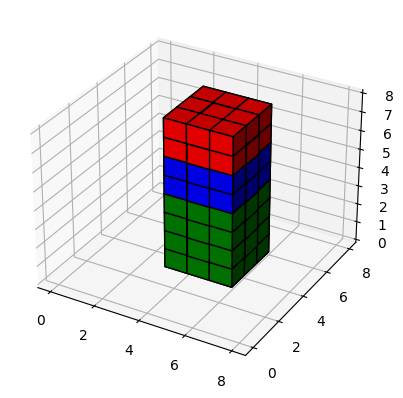

In [1]:
from artefact_nca.dataset.voxel_dataset import VoxelDataset
from artefact_nca.model.voxel_ca_model import VoxelCAModel
from artefact_nca.trainer.voxel_ca_trainer import VoxelCATrainer


import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z < 4)
cube2 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 4) & (z < 6)
cube3 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 6) & (z < 8) 

# link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | cube3

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[cube3] = 'red'
colors[cube1] = 'green'
colors[cube2] = 'blue'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

from artefact_nca.utils.minecraft.voxel_utils import voxel_to_numeric

voxel, target_unique_val_dict = voxel_to_numeric(colors)


In [2]:
target_unique_val_dict, voxel.shape

({0: '_empty', 1: 'blue', 2: 'green', 3: 'red'}, (8, 8, 8))

In [3]:
import torch
print(torch.cuda.is_available())

False


In [4]:
embedding_dimension = 4

In [5]:
x = torch.tensor([1, 2, 3])
x = x.repeat([5,5,5,1])
k = [ num for num in x.shape]
k[-1] = 2
print(k)
x.shape[:-1]

[5, 5, 5, 2]


torch.Size([5, 5, 5])

In [6]:
import attr
import torch.nn.functional as F
import torch
import numpy as np
from einops import rearrange

@attr.s
class CustomMSETrainer(VoxelCATrainer):
    #def get_fitness(self, grown_robot):
    #    return 0
    
    def custom_seed(self, batch_size):
        depth = self.dataset.depth
        height = self.dataset.height
        width = self.dataset.width
        
        seed = np.ones(
                    (batch_size, depth, height, width, self.num_channels)
                ) * 10
        return torch.from_numpy(seed).float().to(self.device)
    
    def train_func(self, x, targets, embeddings = None, steps=1):
        self.optimizer.zero_grad()
        x = self.model(x, embeddings=embeddings, steps=steps, rearrange_output=False)
        #fitness = self.get_fitness(x)
    
        loss, iou_loss = self.get_loss(x, targets)

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        x = rearrange(x, "b c d h w -> b d h w c")
        out = {
            "out": x,
            "metrics": {"loss": loss.item(), "iou_loss": iou_loss.item()},
            "loss": loss,
        }
        return out

    def train_iter(self, batch_size=32, iteration=0):
        batch, targets, indices = self.sample_batch(batch_size)# + embeddings
        #print(batch.shape)#5,8,8,8,15
        #print(targets.shape)#5,8,8,8
        embeddings = torch.tensor([i for i in range(embedding_dimension)])# dummy
        shape_to_emulate = [ num for num in batch.shape]
        shape_to_emulate[-1] = 1
        embedding_input = embeddings.repeat(shape_to_emulate)
        #print(embedding_input.shape)# 5, 8,8,8, embedding_dimension
        
        targets = targets.long()
        
        batch = self.custom_seed(batch_size)
        if self.use_sample_pool:
            with torch.no_grad():
                loss_rank = (
                    self.rank_loss_function(batch, targets)
                    .detach()
                    .cpu()
                    .numpy()
                    .argsort()[::-1]
                )
                batch = batch[loss_rank.copy()]
                batch[:1] = torch.from_numpy(self.get_seed()).to(self.device)

                if self.damage:
                    self.apply_damage(batch)

        steps = np.random.randint(self.min_steps, self.max_steps)
        
        
        if self.half_precision:
            with torch.cuda.amp.autocast():
                out_dict = self.train_func(batch, targets, steps)
        else:
            out_dict = self.train_func(batch, targets,embedding_input, steps)
        out, loss, metrics = out_dict["out"], out_dict["loss"], out_dict["metrics"]

        if self.update_dataset and self.use_sample_pool:
            self.update_dataset_function(out, indices)
        out_dict["prev_batch"] = batch.detach().cpu().numpy()
        out_dict["post_batch"] = out.detach().cpu().numpy()
        return out_dict    


In [7]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

In [8]:
ct.train()

2023-11-28 16:15:32.118 | INFO     | artefact_nca.base.base_torch_trainer:train:297 - Follow tensorboard logs with: tensorboard --logdir checkpoints/2023-11-28-16-15-32_PlainVillageHouse/tensorboard_logs
  0%|          | 0/1500 [00:00<?, ?it/s]


TypeError: forward() got an unexpected keyword argument 'embeddings'

### View model weights

In [ ]:
# why?
#for name, W in ct.model.named_parameters():
#    print(name, W)

In [ ]:
with torch.no_grad():
    for name, W in ct.model.named_parameters():
        W += torch.ones_like(W)

In [ ]:
#for name, W in ct.model.named_parameters():
#    print(name, W)

In [ ]:
weights = ct.model.state_dict()

#### Save model

In [ ]:
torch.save({"model":ct.model.state_dict()}, "test_model.pt")

#### Load Model

In [ ]:
ct.load_model("test_model.pt", load_optimizer_and_scheduler = False)

### Create new trainer from pretrained model

In [ ]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "pretrained_path":"test_model.pt",
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

### Visualize output of NCA

In [ ]:
from IPython.display import clear_output
from artefact_nca.utils.minecraft.voxel_utils import replace_colors

def visualize_output(ct, out):
    clear_output()
    out = rearrange(out, 'b d h w c -> b w d h c')
    argmax = np.argmax(out[:, :, :, :, :ct.num_categories], -1)
    out = replace_colors(argmax, ct.dataset.target_color_dict)[0]
    fig = plt.figure()
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(out, facecolors=out, edgecolor='k')
    
    plt.show()
    return argmax

<Figure size 640x480 with 0 Axes>

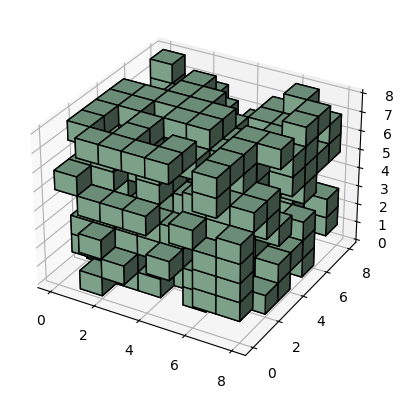

In [ ]:
seed = np.ones(
            (1, 8, 8, 8, ct.num_channels)
        )
seed[:, :, :, :, 1:] = 10.0
seed = torch.from_numpy(seed).float().to(ct.device)

with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=seed)

_ = visualize_output(ct, final.cpu().numpy())

#### another step

<Figure size 640x480 with 0 Axes>

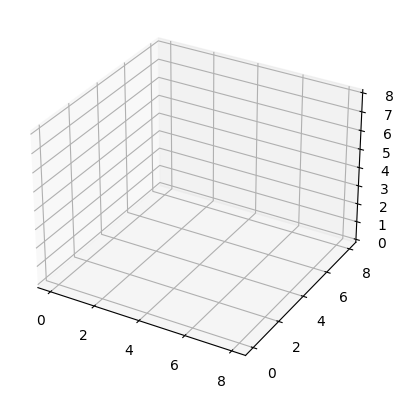

In [ ]:
with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=final)

_ = visualize_output(ct, final.cpu().numpy())